# 0. Loading

First we activate the `examples` environment and then we load a couple of packages

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using Revise, PtyLab, Parameters, EllipsisNotation, Colors
using ImageShow, ImageCore, FFTW, BenchmarkTools, ImageIO, Downloads, HDF5, Plots, ColorSchemes
using IndexFunArrays
FFTW.set_num_threads(4)

  Activating project at `~/.julia/dev/PtyLab.jl/examples`
Precompiling project...
  ✓ PtyLab
  1 dependency successfully precompiled in 7 seconds. 328 already precompiled.


# 1. Data Download

It is ~350MB large, so please be patient for a few moments (or minutes).
The file is stored temporarily somewhere else. So if you restart this notebook, it downloads it again.
However, you can also manually specify the file path down below.

This data is part of the following publication:
Loetgering, Lars, et al. "Generation and characterization of focused helical x-ray beams." Science advances 6.7 (2020): eaax8836.

In [2]:
dataset = Downloads.download("https://figshare.com/ndownloader/files/38419391", verbose=true)

* Couldn't find host figshare.com in the (nil) file; using defaults
*   Trying 34.253.18.52:443...
* Connected to figshare.com (34.253.18.52) port 443 (#0)
* mbedTLS: Connecting to figshare.com:443
* mbedTLS: Set min SSL version to TLS 1.0
* ALPN: offers h2
* ALPN: offers http/1.1
* mbedTLS: Handshake complete, cipher is TLS-ECDHE-RSA-WITH-AES-128-GCM-SHA256
* Dumping cert info: * cert. version     : 3
* serial number     : 06:84:57:DC:03:6E:5E:FD:D5:17:8C:39:07:4B:9B:A7
* issuer name       : C=US, O=Amazon, CN=Amazon RSA 2048 M02
* subject name      : CN=*.figshare.com
* issued  on        : 2023-02-10 00:00:00
* expires on        : 2023-04-26 23:59:59
* signed using      : RSA with SHA-256
* RSA key size      : 2048 bits
* basic constraints : CA=false
* subject alt name  :
*     dNSName : *.figshare.com
*     dNSName : figshare.com
* key usage         : Digital Signature, Key Encipherment
* ext key usage     : TLS Web Server Authentication, TLS Web Client Authentication
* certificate 

"/tmp/jl_sb2RIjiTkX"

# 2. Load into ExperimentalDataCPM

In [3]:
datah5 = h5open(dataset, "r")

🗂️ HDF5.File: (read-only) /tmp/jl_sb2RIjiTkX
├─ 🔢 dxd
├─ 🔢 encoder
├─ 🔢 ptychogram
├─ 🔢 wavelength
└─ 🔢 zo

In [4]:
experimentalData = ExperimentalDataCPM(dataset);

[ Info: Reading HDF5.File: (read-only) /tmp/jl_sb2RIjiTkX was successful


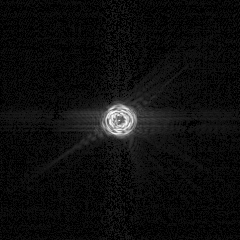

In [5]:
simshow(experimentalData.ptychogram[:, :, 1], γ=0.3)

# 3. Load into ReconstructionCPM

In [17]:
reconstruction = ReconstructionCPM(experimentalData, cuda=true);

┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab ~/.julia/dev/PtyLab.jl/src/utils_calc.jl:91


In [18]:
# transpose is necessary in this case
reconstruction.encoder = reconstruction.encoder'

2×1600 adjoint(::Matrix{Float32}) with eltype Float32:
 -5.92875f-6  -5.78236f-6  -5.63597f-6  …  -2.19583f-7  -7.31944f-8
 -5.92875f-6  -5.92875f-6  -5.92875f-6     -7.31944f-8  -7.31944f-8

In [19]:
reconstruction.encoder .-= mean(reconstruction.encoder, dims=(2,))

2×1600 Matrix{Float32}:
 -2.92778f-6  -2.78139f-6  -2.635f-6    …  2.635f-6    2.78139f-6  2.92778f-6
 -2.92777f-6  -2.92777f-6  -2.92777f-6     2.92778f-6  2.92778f-6  2.92778f-6

# 4. Choose engine

In [20]:
params = Params(fftshiftFlag = false, 
                 transposePtychogram = false, 
                 comStabilizationSwitch = true,
                 randPositionOrder = true)

engine = PtyLab.ePIE(betaProbe = 0.75f0, betaObject = 0.75f0, numIterations = 20)

ePIE{Float32}
  betaProbe: Float32 0.75f0
  betaObject: Float32 0.75f0
  numIterations: Int64 20


In [21]:
reconstruction.npsm = 2

2

In [22]:
reconstruction.entrancePupilDiameter = reconstruction.Np/3 * reconstruction.dxp

2.9277777002789662e-6

# 5. Reconstruct

In [23]:
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

In [24]:
#reconstruction.probe .*= randn(size(reconstruction.probe)) ;
#reconstruction.probe .*= cis.(rr2(size(reconstruction.probe), scale=0.12));

In [28]:
@time p, o = PtyLab.reconstruct(engine, params, reconstruction);

┌ Warning: gimmel is currently estimated as `eps(Float32)`
└ @ PtyLab ~/.julia/dev/PtyLab.jl/src/Engines.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 13.895038 seconds (33.91 M allocations: 2.687 GiB, 2.42% gc time)


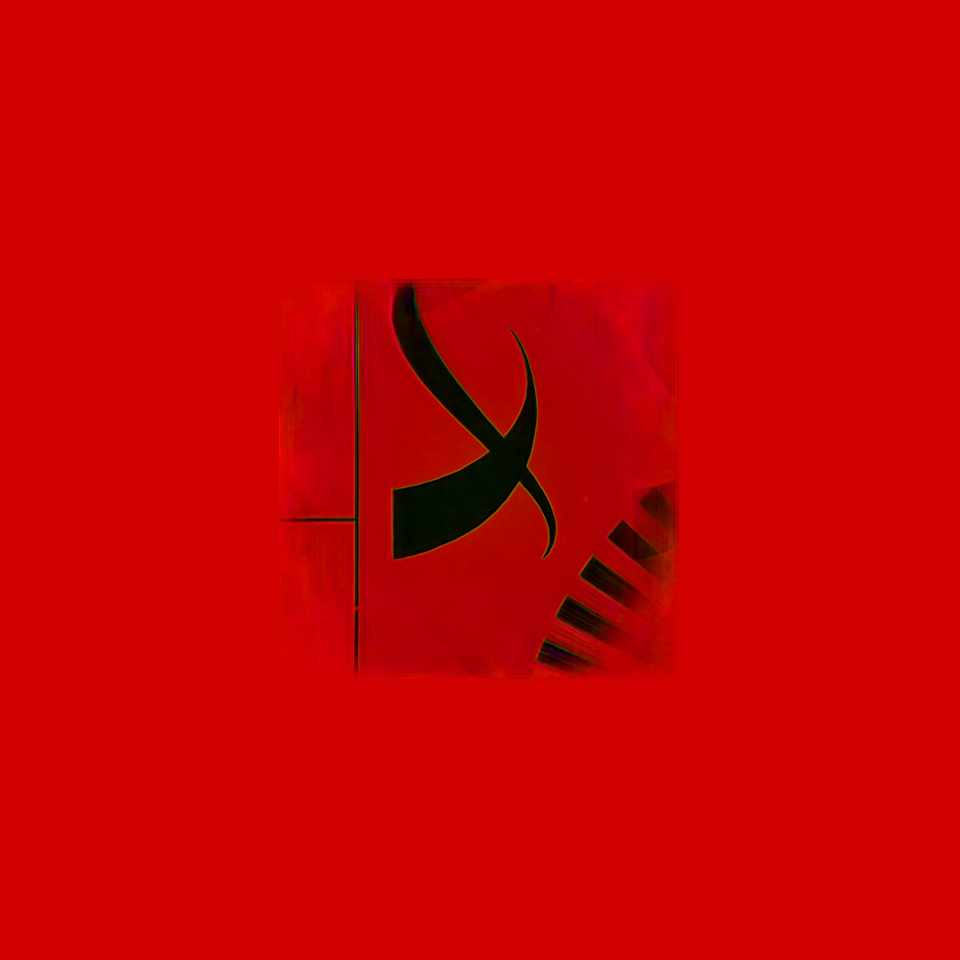

In [26]:
simshow(Array(reconstruction.object[:, :, 1,1,1,1]))

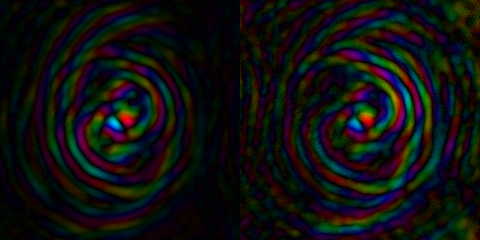

In [27]:
[simshow(Array(reconstruction.probe[:, :, 1,1,1,1])) simshow(Array(reconstruction.probe[:, :, 1,1,2,1]))]